In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
market_open = pd.Timestamp("09:30:00").time()
market_close = pd.Timestamp("16:00:00").time()

In [33]:
def resample_mid_prices(raw_data, sampling_rate, returns_discretization="10ms"):
    df = raw_data.copy()
    df["mid_price"] = df[["ask_px_00", "bid_px_00"]].mean(axis=1)
    df["mid_price"] = df["mid_price"].combine_first(df["ask_px_00"])
    df["mid_price"] = df["mid_price"].combine_first(df["bid_px_00"])

    # Compute volatility
    mid_prices_discretized = df["mid_price"].resample(returns_discretization).last()
    mid_prices_evolution_discretized = mid_prices_discretized.pct_change(
        fill_method=None
    )
    mid_price_volatilitiy = mid_prices_evolution_discretized.resample(
        sampling_rate
    ).std()

    # Compute returns
    mid_prices_last = df["mid_price"].resample(sampling_rate).last()
    mid_price_variation = mid_prices_last.pct_change(fill_method=None)
    mid_price_variation_class = np.sign(mid_price_variation)

    # Compute OHLC prices
    mid_prices = pd.DataFrame(
        {
            "mid_price_first": df["mid_price"].resample(sampling_rate).first(),
            "mid_price_high": df["mid_price"].resample(sampling_rate).max(),
            "mid_price_low": df["mid_price"].resample(sampling_rate).min(),
            "mid_price_last": mid_prices_last,
        }
    )

    # Compute trade-based close, high, and low prices
    df_trades = df[df["action"] == "T"]
    close = df_trades["price"].resample(sampling_rate).last().ffill()
    high = df_trades["price"].resample(sampling_rate).max().ffill()
    low = df_trades["price"].resample(sampling_rate).min().ffill()
    open = df_trades["price"].resample(sampling_rate).first().ffill()

    return pd.concat(
        [
            mid_prices,
            close.rename("close"),
            high.rename("high"),
            low.rename("low"),
            open.rename("open"),
            mid_price_variation.rename("mid_price_variation"),
            mid_price_variation_class.rename("mid_price_variation_class"),
            mid_price_volatilitiy.rename("mid_price_volatility"),
        ],
        axis=1,
    ).dropna()

In [ ]:
import pandas as pd
import ta

def compute_technical_indicators(mid_prices_data):
    """
    Compute technical indicators for a given DataFrame with OHLC-like structure.
    """
    df = mid_prices_data.copy()

    ### TREND INDICATORS ###
    df['ADX_5'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_last'], window=5).adx()
    df['ADX_7'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_last'], window=7).adx()
    df['ADX_10'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_last'], window=10).adx()
    df['DMP_5'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_last'], window=5).adx_pos()
    df['DMP_10'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_last'], window=10).adx_pos()
    df['DMN_5'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_last'], window=5).adx_neg()
    df['DMN_10'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_last'], window=10).adx_neg()
    
    # Aroon Indicator requires both high and low prices
    df['AROONU_7'] = ta.trend.AroonIndicator(df['mid_price_high'], df['mid_price_low'], window=7).aroon_up()
    df['AROOND_7'] = ta.trend.AroonIndicator(df['mid_price_high'], df['mid_price_low'], window=7).aroon_down()
    
    # Open-Low and Open-High calculations
    df['OLL3'] = df['mid_price_first'] - df['mid_price_low'].rolling(window=3).min()
    df['OLL5'] = df['mid_price_first'] - df['mid_price_low'].rolling(window=5).min()
    df['OLL10'] = df['mid_price_first'] - df['mid_price_low'].rolling(window=10).min()
    df['OLL15'] = df['mid_price_first'] - df['mid_price_low'].rolling(window=15).min()
    df['OHH3'] = df['mid_price_high'].rolling(window=3).max() - df['mid_price_first']
    df['OHH5'] = df['mid_price_high'].rolling(window=5).max() - df['mid_price_first']
    
    ### OSCILLATORS ###
    df['STOCHk_14_3_3'] = ta.momentum.StochasticOscillator(df['mid_price_high'], df['mid_price_low'], df['mid_price_last'], window=14, smooth_window=3).stoch()
    df['STOCHd_14_3_3'] = ta.momentum.StochasticOscillator(df['mid_price_high'], df['mid_price_low'], df['mid_price_last'], window=14, smooth_window=3).stoch_signal()

    # Avoid NaN Stochastic values
    df['STOCHk_14_3_3'] = df['STOCHk_14_3_3'].ffill()
    df['STOCHd_14_3_3'] = df['STOCHd_14_3_3'].ffill()

    df['MACD_8_21_5'] = ta.trend.MACD(df['mid_price_last'], window_slow=21, window_fast=8, window_sign=5).macd_diff()
    df['RSI_7'] = ta.momentum.RSIIndicator(df['mid_price_last'], window=7).rsi()
    df['AO_5_10'] = ta.momentum.AwesomeOscillatorIndicator(df['mid_price_high'], df['mid_price_low'], window1=5, window2=10).awesome_oscillator()

    ### MOVING AVERAGES ###
    df['EMA_15'] = ta.trend.EMAIndicator(df['mid_price_last'], window=15).ema_indicator()
    df['HMA_10'] = ta.trend.WMAIndicator(df['mid_price_last'], window=10).wma()  # HMA is not directly available in 'ta', using WMA as a placeholder
    df['KAMA_3_2_10'] = ta.momentum.KAMAIndicator(df['mid_price_last'], window=3, pow1=2, pow2=10).kama()
    df['SMA_10'] = ta.trend.SMAIndicator(df['mid_price_last'], window=10).sma_indicator()
    df['SMA_5'] = ta.trend.SMAIndicator(df['mid_price_last'], window=5).sma_indicator()
    
    # Rolling CO (Close - Open)
    for w in [3, 4, 5, 6]:
        df[f'rmCO({w})'] = (df['mid_price_last'] - df['mid_price_first']).rolling(window=w).mean()
    
    ### VOLATILITY INDICATORS ###
    df['Bollinger_Upper'] = ta.volatility.BollingerBands(df['mid_price_last'], window=10, window_dev=2).bollinger_hband()
    df['Bollinger_Lower'] = ta.volatility.BollingerBands(df['mid_price_last'], window=10, window_dev=2).bollinger_lband()
    df['U_minus_L'] = df['Bollinger_Upper'] - df['Bollinger_Lower']
    df['MA10dSTD'] = df['mid_price_last'].rolling(window=10).std()
    df["volatility_5s"] = df["mid_price_volatility"].rolling(window=5).mean()
    df['volatility_10s'] = df['mid_price_last'].rolling(window=10).std()

    ### OTHER INDICATORS ###
    df['CO'] = df['mid_price_last'] - df['mid_price_first']
    df["C1O1"] = df["CO"].shift(1)
    df['C2O2'] = df["CO"].shift(2)
    df['C3O3'] = df["CO"].shift(3)
    df['range'] = df['mid_price_high'] - df['mid_price_low']
    df['OH1'] = df['mid_price_high'].shift(1) - df['mid_price_first'].shift(1)

    ### ADDITIONAL FEATURES ###
    # Price changes
    df['price_change_1s'] = df['mid_price_last'].diff()
    df['price_change_5s'] = df['mid_price_last'].diff(5)
    df['price_change_10s'] = df['mid_price_last'].diff(10)


    # Momentum
    df['momentum_5s'] = ta.momentum.ROCIndicator(df['mid_price_last'], window=5).roc()
    df['momentum_10s'] = ta.momentum.ROCIndicator(df['mid_price_last'], window=10).roc()

    # Rate of Change (ROC)
    df['roc_5s'] = ta.momentum.ROCIndicator(df['mid_price_last'], window=5).roc()
    df['roc_10s'] = ta.momentum.ROCIndicator(df['mid_price_last'], window=10).roc()

    return df.dropna()

In [35]:
def add_time_features(combined_df):

    # Compute seconds since market open (9:30 AM)
    market_open_time = combined_df.index.normalize() + pd.Timedelta(hours=9, minutes=30)
    combined_df["time_since_open"] = (combined_df.index - market_open_time).dt.total_seconds()

    # Add binary features for Monday and Friday
    combined_df["is_monday"] = (combined_df.index.weekday == 0).astype(int)  # Monday = 0
    combined_df["is_friday"] = (combined_df.index.weekday == 4).astype(int)  # Friday = 4

    # Add market session feature (morning = 0, afternoon = 1)
    combined_df["market_session"] = (combined_df["time_since_open"] > 3.5 * 3600).astype(int)

    return combined_df

In [121]:
def compute_order_book_features(raw_data, resample_rate):

    df = raw_data.copy()

    # Compute the mid-price as the average of best bid/ask prices
    df["mid_price"] = df[["ask_px_00", "bid_px_00"]].mean(axis=1)
    df["mid_price"] = df["mid_price"].fillna(df["ask_px_00"])
    df["mid_price"] = df["mid_price"].fillna(df["bid_px_00"])

    # Precompute masks for filtering specific actions
    trade_mask = df["action"] == "T"
    add_mask = df["action"] == "A"
    cancel_mask = df["action"] == "C"
    bid_mask = df["side"] == "B"
    ask_mask = df["side"] == "A"

    # Aggregate resampled data using efficient functions
    resampled_data = df.resample(resample_rate).agg({
        "mid_price": ["first", "last", "max", "min", "mean", "std"],
        "bid_px_00": ["last", "mean", "std"],
        "ask_px_00": ["last", "mean", "std"],
        "bid_sz_00": ["last", "mean", "std"],
        "ask_sz_00": ["last", "mean", "std"],
        "ask_px_01": "mean",
        "bid_px_01": "mean"
    })

    # Rename columns for clarity
    resampled_data.columns = [
        "mid_price_first", "mid_price_last", "mid_price_high", "mid_price_low", "mean_mid_price", "std_mid_price",
        "best_bid_price", "mean_best_bid_price", "std_best_bid_price",
        "best_ask_price", "mean_best_ask_price", "std_best_ask_price",
        "best_bid_size", "mean_best_bid_size", "std_best_bid_size",
        "best_ask_size", "mean_best_ask_size", "std_best_ask_size",
        "mean_second_bid_ask_spread", "mean_second_bid_price"
    ]

    # Forward-fill missing bid/ask sizes
    resampled_data[["best_bid_size", "best_ask_size"]] = resampled_data[["best_bid_size", "best_ask_size"]].ffill()

    # Compute derived features
    resampled_data["bid_ask_spread"] = resampled_data["best_ask_price"] - resampled_data["best_bid_price"]
    resampled_data["mid_price_variation"] = resampled_data["mid_price_last"] / resampled_data["mid_price_first"] - 1
    resampled_data["mid_price_variation_class"] = np.sign(resampled_data["mid_price_variation"])

    # Compute trade-related values
    trade_prices = df.loc[trade_mask, "price"].resample(resample_rate).agg(["first", "last", "max", "min"])
    trade_prices.columns = ["trade_open", "trade_close", "trade_high", "trade_low"]
    
    # Compute total bid/ask volume (additions - cancellations)
    resampled_data["total_bid_volume"] = (
        df.loc[add_mask & bid_mask, "size"].astype("int64").resample(resample_rate).sum().fillna(0) -
        df.loc[cancel_mask & bid_mask, "size"].astype("int64").resample(resample_rate).sum().fillna(0)
    )
    resampled_data["total_ask_volume"] = (
        df.loc[add_mask & ask_mask, "size"].astype("int64").resample(resample_rate).sum().fillna(0) -
        df.loc[cancel_mask & ask_mask, "size"].astype("int64").resample(resample_rate).sum().fillna(0)
    )

    # Compute order book imbalance metrics
    resampled_data["mean_order_book_imbalance"] = resampled_data["mean_best_bid_size"] - resampled_data["mean_best_ask_size"]
    resampled_data["mean_volume_ratio_bid_ask"] = resampled_data["mean_best_bid_size"] / resampled_data["mean_best_ask_size"]
    resampled_data["total_net_order_flow"] = resampled_data["best_bid_size"].astype("int64") - resampled_data["best_ask_size"].astype("int64")

    # Count order actions
    resampled_data["num_added_orders"] = df.loc[add_mask].resample(resample_rate).size()
    resampled_data["num_canceled_orders"] = df.loc[cancel_mask].resample(resample_rate).size()
    resampled_data["num_traded_orders"] = df.loc[trade_mask].resample(resample_rate).size()

    # Compute rolling averages (5s window)
    resampled_data["order_book_imbalance_5s"] = resampled_data["mean_order_book_imbalance"].rolling(5).mean()
    resampled_data["volume_ratio_5s"] = resampled_data["mean_volume_ratio_bid_ask"].rolling(5).mean()
    resampled_data["order_flow_5s"] = resampled_data["total_net_order_flow"].rolling(5).mean()

    # Merge trade data with resampled data
    resampled_data = resampled_data.merge(trade_prices, left_index=True, right_index=True, how="left")

    # Drop NaNs from rolling calculations
    resampled_data.dropna(inplace=True)

    return resampled_data


In [122]:
AAPL_data_path = "AAPL_data/AAPL_2024-10-01_xnas-itch.parquet"

raw_data = pd.read_parquet(AAPL_data_path)

raw_data = raw_data.between_time(market_open, market_close)

resampled_data = compute_order_book_features(raw_data, "500ms")

print(resampled_data.columns)
resampled_data.head()

Index(['mid_price_first', 'mid_price_last', 'mid_price_high', 'mid_price_low',
       'mean_mid_price', 'std_mid_price', 'best_bid_price',
       'mean_best_bid_price', 'std_best_bid_price', 'best_ask_price',
       'mean_best_ask_price', 'std_best_ask_price', 'best_bid_size',
       'mean_best_bid_size', 'std_best_bid_size', 'best_ask_size',
       'mean_best_ask_size', 'std_best_ask_size', 'mean_second_bid_ask_spread',
       'mean_second_bid_price', 'bid_ask_spread', 'mid_price_variation',
       'mid_price_variation_class', 'total_bid_volume', 'total_ask_volume',
       'mean_order_book_imbalance', 'mean_volume_ratio_bid_ask',
       'total_net_order_flow', 'num_added_orders', 'num_canceled_orders',
       'num_traded_orders', 'order_book_imbalance_5s', 'volume_ratio_5s',
       'order_flow_5s', 'trade_open', 'trade_close', 'trade_high',
       'trade_low'],
      dtype='object')


,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mean_mid_price,std_mid_price,best_bid_price,mean_best_bid_price,std_best_bid_price,best_ask_price,...,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,volume_ratio_5s,order_flow_5s,trade_open,trade_close,trade_high,trade_low
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:02-04:00,229.025,229.300,229.30,229.025,229.159568,0.067259,229.27,229.139971,0.068332,229.33,...,289,264,130,14.331100,1.568408,372.6,229.05,229.27,229.31,229.05
2024-10-01 09:30:02.500000-04:00,229.300,229.150,229.30,229.150,229.210855,0.035973,229.13,229.180446,0.033388,229.17,...,127,88,54,49.335678,1.602838,188.2,229.27,229.17,229.27,229.17
2024-10-01 09:30:03-04:00,229.150,229.020,229.15,229.020,229.085642,0.036071,229.00,229.063321,0.037167,229.04,...,123,98,44,87.956782,1.698172,1501.8,229.15,229.01,229.16,229.01
2024-10-01 09:30:03.500000-04:00,229.020,229.145,229.15,229.020,229.079597,0.037911,229.12,229.050161,0.036314,229.17,...,54,53,17,269.718157,2.812521,1494.2,229.04,229.16,229.16,229.04
2024-10-01 09:30:04-04:00,229.145,229.115,229.18,229.115,229.156364,0.019129,229.08,229.130341,0.027226,229.15,...,46,35,7,203.872264,2.203879,1347.0,229.16,229.16,229.19,229.16


In [105]:
np.sign(resampled_data.mid_price_last.pct_change()).dropna().value_counts()

mid_price_last
-1.0    7837
 1.0    7725
 0.0    2684
Name: count, dtype: int64

In [14]:
# Resample the data to 1-second intervals and count the changes in mid_price
changes = raw_data['mid_price'].diff().ne(0).astype(int)
changes_per_second = changes.resample('1s').sum()

print(changes_per_second)

C:\Users\Laurent Liao\AppData\Local\Temp\ipykernel_7880\516501264.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  changes_per_second = changes.resample('1S').sum()


ts_recv
2024-10-01 09:30:00-04:00    225
2024-10-01 09:30:01-04:00    245
2024-10-01 09:30:02-04:00    202
2024-10-01 09:30:03-04:00     93
2024-10-01 09:30:04-04:00     45
                            ... 
2024-10-01 15:59:55-04:00    165
2024-10-01 15:59:56-04:00    104
2024-10-01 15:59:57-04:00    178
2024-10-01 15:59:58-04:00     29
2024-10-01 15:59:59-04:00     96
Freq: s, Name: mid_price, Length: 23400, dtype: int32


<Axes: title={'center': 'Number of mid_price changes per second'}, xlabel='ts_recv'>

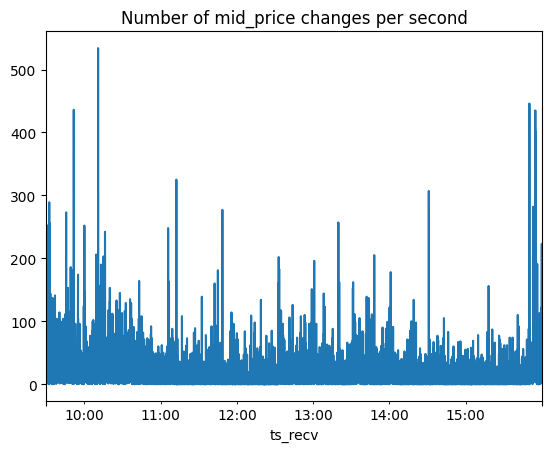

In [15]:
changes_per_second.plot(title='Number of mid_price changes per second')

In [17]:
data = resample_mid_prices(raw_data, "1s")
data.head()

,mid_price_first,mid_price_high,mid_price_low,mid_price_last,close,high,low,open,mid_price_variation,mid_price_variation_class,mid_price_volatility
ts_recv,,,,,,,,,,,
2024-10-01 09:30:01-04:00,229.390,229.435,229.010,229.025,229.03,229.44,229.00,229.40,-0.001591,-1.0,0.000054
2024-10-01 09:30:02-04:00,229.025,229.300,229.025,229.150,229.17,229.31,229.05,229.05,0.000546,1.0,0.000079
2024-10-01 09:30:03-04:00,229.150,229.150,229.020,229.145,229.16,229.16,229.01,229.15,-0.000022,-1.0,0.000035
2024-10-01 09:30:04-04:00,229.145,229.180,229.080,229.135,229.14,229.19,229.13,229.16,-0.000044,-1.0,0.000051
2024-10-01 09:30:05-04:00,229.135,229.215,229.120,229.145,229.21,229.21,229.14,229.14,0.000044,1.0,0.000035


In [12]:
data["mid_price_variation_class"].value_counts()

mid_price_variation_class
 1.0    6150
-1.0    5845
 0.0    5713
Name: count, dtype: int64

In [ ]:

df = resample_mid_prices(raw_data, sampling_rate='1s')

df.iloc[:20]

,open,high,low,close,volatilities
ts_event,,,,,
2024-10-21 09:30:00-04:00,234.425,234.475,234.425,234.475,0.000068
2024-10-21 09:30:01-04:00,234.610,234.705,234.580,234.665,0.000101
2024-10-21 09:30:02-04:00,234.790,234.790,234.790,234.790,0.000044
2024-10-21 09:30:03-04:00,234.865,234.880,234.865,234.880,0.000074
2024-10-21 09:30:04-04:00,234.705,234.705,234.705,234.705,0.000050
2024-10-21 09:30:05-04:00,234.740,234.740,234.740,234.740,0.000041
2024-10-21 09:30:06-04:00,234.705,234.705,234.705,234.705,0.000051
2024-10-21 09:30:07-04:00,234.850,234.850,234.850,234.850,0.000032
2024-10-21 09:30:08-04:00,234.865,234.865,234.865,234.865,0.000035


In [ ]:

technical_indicators = compute_technical_indicators(mid_prices)

df_combined.columns

df_combined.drop(columns=['mid_price_high', 'mid_price_low', 'mid_price_last', 'mid_price_first'], inplace=True)
df_combined.columns

Index(['trade_ask_size', 'trade_bid_size', 'net_add_ask_size',
       'net_add_bid_size', 'returns', 'volatilities', 'ADX_5', 'ADX_7',
       'ADX_10', 'DMP_5', 'DMP_10', 'DMN_5', 'DMN_10', 'AROONU_7', 'AROOND_7',
       'OLL3', 'OLL5', 'OLL10', 'OLL15', 'OHH3', 'OHH5', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'MACD_8_21_5', 'RSI_7', 'AO_5_10', 'EMA_15', 'HMA_10',
       'KAMA_3_2_10', 'MA_10', 'MA_20', 'rmCO(3)', 'rmCO(4)', 'rmCO(5)',
       'rmCO(6)', 'Bollinger_Upper', 'Bollinger_Lower', 'U_minus_L',
       'MA20dSTD', 'CO', 'C1O1', 'C2O2', 'C3O3', 'range', 'OH1'],
      dtype='object')

# Feature selection

In [ ]:
start_date = pd.to_datetime("2024-10-01")
end_date = pd.to_datetime("2024-10-01")
date_range = pd.bdate_range(start=start_date, end=end_date)
data_paths = [f"AAPL_data/AAPL_{date.strftime('%Y-%m-%d')}_xnas-itch.parquet" for date in date_range]

sampling_rate = '1s'

trade_days_data = []

for path in data_paths:
    df = pd.read_parquet(path)
    df = df.reset_index().set_index("ts_event")

    df = df.between_time(market_open, market_close)
    
    order_sizes = group_and_pivot_order_sizes(df, sampling_rate=sampling_rate)
    

    mid_prices = resample_mid_prices(df, sampling_rate=sampling_rate)
    
    order_sizes = order_sizes.reindex(mid_prices.index, fill_value=0)

    technical_indicators = compute_technical_indicators(mid_prices)
    df_combined = order_sizes.join(technical_indicators, how='inner')

    df_combined.drop(columns=['mid_price_high', 'mid_price_low', 'mid_price_last', 'mid_price_first'], inplace=True)

    trade_days_data.append(df_combined)

all_data = pd.concat(trade_days_data)

print(all_data.shape)

all_data.head()


(23376, 45)


,trade_ask_size,trade_bid_size,net_add_ask_size,net_add_bid_size,returns,volatilities,ADX_5,ADX_7,ADX_10,DMP_5,...,Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:24-04:00,1041.0,3230.0,33.0,3732.0,0.000481,0.000013,52.029224,45.330287,58.642027,22.322902,...,229.170690,228.561310,0.609380,0.156303,0.110,-0.070,0.040,0.165,0.145,0.000
2024-10-01 09:30:25-04:00,938.0,553.0,2364.0,-1297.0,-0.000415,0.000009,52.011413,41.708987,53.639974,18.964037,...,229.127744,228.574756,0.552987,0.141838,-0.095,0.110,-0.070,0.040,0.095,0.115
2024-10-01 09:30:26-04:00,476.0,1450.0,-570.0,1181.0,0.000175,0.000012,51.997164,38.605016,49.138126,16.655746,...,229.086905,228.592095,0.494809,0.126916,0.035,-0.095,0.110,-0.070,0.065,0.000
2024-10-01 09:30:27-04:00,660.0,911.0,-74.0,1714.0,0.000350,0.000010,56.237268,39.306055,45.381648,27.236266,...,229.064057,228.603943,0.460113,0.118017,0.080,0.035,-0.095,0.110,0.115,0.065
2024-10-01 09:30:28-04:00,310.0,0.0,550.0,82.0,-0.000131,0.000008,59.629351,39.906946,42.000819,25.310702,...,229.034060,228.619940,0.414121,0.106220,-0.030,0.080,0.035,-0.095,0.035,0.110


In [ ]:
all_data["returns"] = all_data["returns"].shift(-1)
all_data.dropna(inplace=True)

In [ ]:
all_data.head()

,trade_ask_size,trade_bid_size,net_add_ask_size,net_add_bid_size,returns,volatilities,ADX_5,ADX_7,ADX_10,DMP_5,...,Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:24-04:00,1041.0,3230.0,33.0,3732.0,-0.000415,0.000013,52.029224,45.330287,58.642027,22.322902,...,229.170690,228.561310,0.609380,0.156303,0.110,-0.070,0.040,0.165,0.145,0.000
2024-10-01 09:30:25-04:00,938.0,553.0,2364.0,-1297.0,0.000175,0.000009,52.011413,41.708987,53.639974,18.964037,...,229.127744,228.574756,0.552987,0.141838,-0.095,0.110,-0.070,0.040,0.095,0.115
2024-10-01 09:30:26-04:00,476.0,1450.0,-570.0,1181.0,0.000350,0.000012,51.997164,38.605016,49.138126,16.655746,...,229.086905,228.592095,0.494809,0.126916,0.035,-0.095,0.110,-0.070,0.065,0.000
2024-10-01 09:30:27-04:00,660.0,911.0,-74.0,1714.0,-0.000131,0.000010,56.237268,39.306055,45.381648,27.236266,...,229.064057,228.603943,0.460113,0.118017,0.080,0.035,-0.095,0.110,0.115,0.065
2024-10-01 09:30:28-04:00,310.0,0.0,550.0,82.0,0.000044,0.000008,59.629351,39.906946,42.000819,25.310702,...,229.034060,228.619940,0.414121,0.106220,-0.030,0.080,0.035,-0.095,0.035,0.110


Correlation Matrix:
                  trade_ask_size  trade_bid_size  net_add_ask_size  \
trade_ask_size          1.000000        0.282152          0.273488   
trade_bid_size          0.282152        1.000000         -0.044556   
net_add_ask_size        0.273488       -0.044556          1.000000   
net_add_bid_size        0.052906        0.307266         -0.323540   
ADX_5                   0.032886        0.040405          0.005717   
ADX_7                   0.030097        0.038824          0.007089   
ADX_10                  0.031778        0.043009          0.009521   
DMP_5                  -0.085756        0.209083         -0.179280   
DMP_10                 -0.079242        0.160148         -0.135483   
DMN_5                   0.161040       -0.110974          0.200363   
DMN_10                  0.134510       -0.091858          0.152032   
AROONU_7               -0.009299        0.192706         -0.068717   
AROOND_7                0.129622       -0.011149          0.105555   


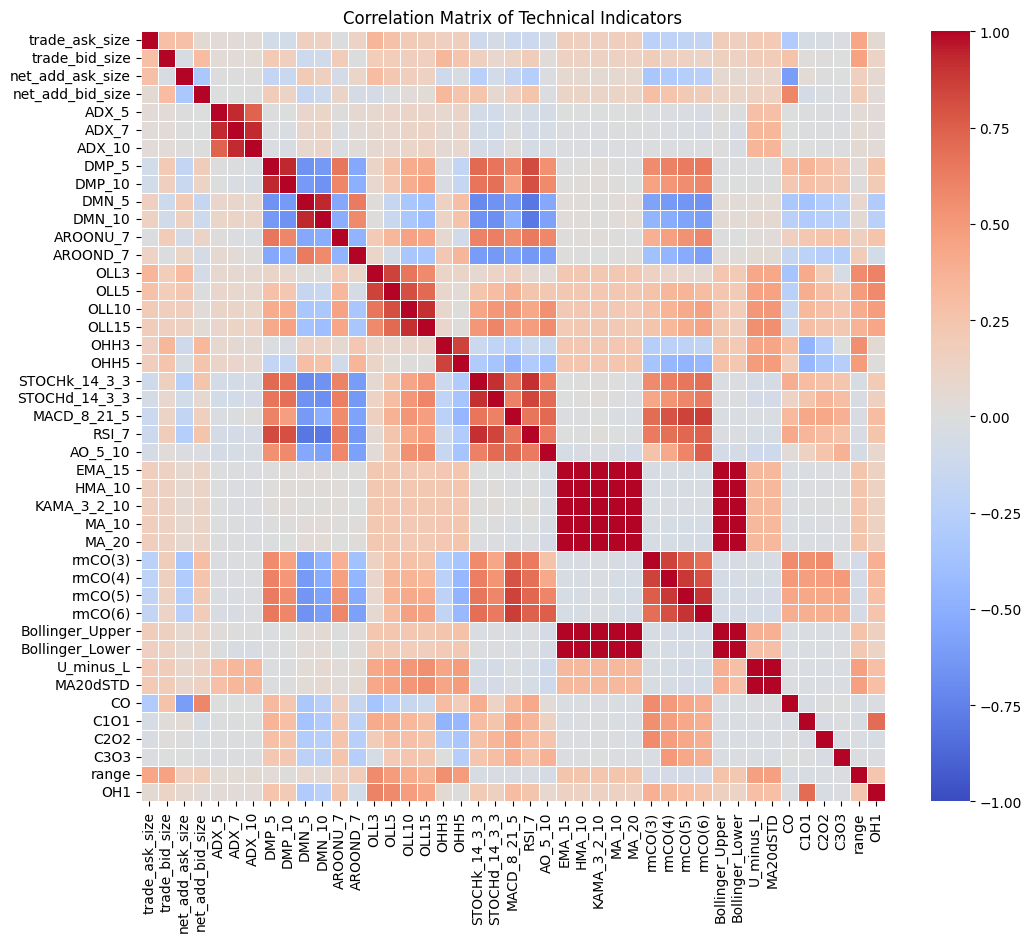

In [ ]:
import seaborn as sns

correlation_matrix = all_data.drop(columns=["returns", "volatilities"]).corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix of Technical Indicators")
plt.show()

# Random Forest

Top 20 Most Important Features:
             Feature  Importance
3   net_add_bid_size    0.041038
2   net_add_ask_size    0.037107
21       MACD_8_21_5    0.036747
6             ADX_10    0.036675
23           AO_5_10    0.034291
4              ADX_5    0.032406
10            DMN_10    0.032105
0     trade_ask_size    0.029910
1     trade_bid_size    0.029198
8             DMP_10    0.027539
9              DMN_5    0.027414
5              ADX_7    0.027320
7              DMP_5    0.026998
22             RSI_7    0.026777
36          MA20dSTD    0.026517
40              C3O3    0.026244
39              C2O2    0.026235
35         U_minus_L    0.025843
20     STOCHd_14_3_3    0.025676
32           rmCO(6)    0.023873


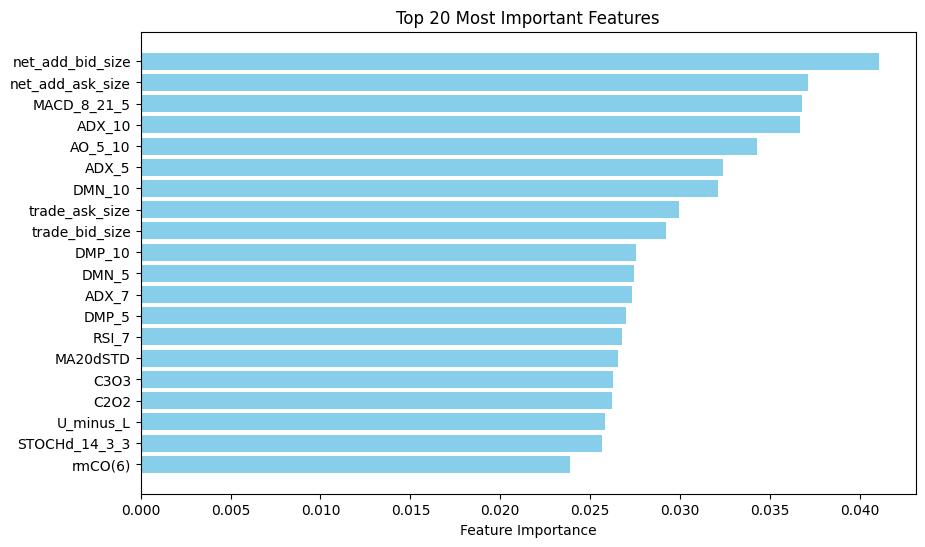

Top 20 Most Important Features:
             Feature  Importance
3   net_add_bid_size    0.042422
2   net_add_ask_size    0.037388
21       MACD_8_21_5    0.035845
6             ADX_10    0.035751
10            DMN_10    0.033589
23           AO_5_10    0.033559
4              ADX_5    0.031941
0     trade_ask_size    0.029078
1     trade_bid_size    0.028199
5              ADX_7    0.027862
9              DMN_5    0.027661
35         U_minus_L    0.027595
8             DMP_10    0.027471
40              C3O3    0.026851
7              DMP_5    0.026525
20     STOCHd_14_3_3    0.026464
36          MA20dSTD    0.026185
22             RSI_7    0.025979
39              C2O2    0.025807
32           rmCO(6)    0.024891


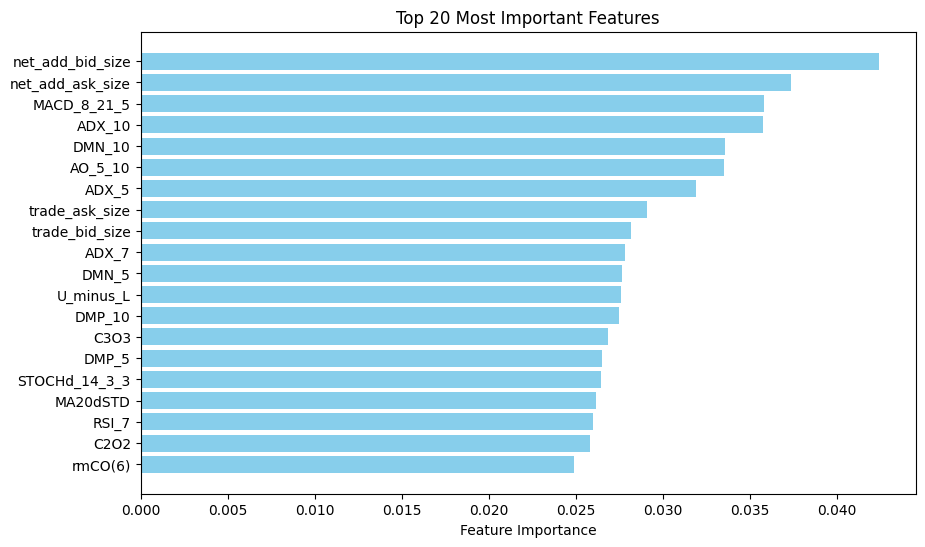

Top 20 Most Important Features:
             Feature  Importance
3   net_add_bid_size    0.043210
2   net_add_ask_size    0.040907
21       MACD_8_21_5    0.038671
6             ADX_10    0.035371
23           AO_5_10    0.034947
4              ADX_5    0.032872
0     trade_ask_size    0.032433
10            DMN_10    0.030899
1     trade_bid_size    0.030829
5              ADX_7    0.029680
8             DMP_10    0.029483
9              DMN_5    0.028946
20     STOCHd_14_3_3    0.027543
7              DMP_5    0.027165
22             RSI_7    0.026954
36          MA20dSTD    0.026874
35         U_minus_L    0.026025
40              C3O3    0.025408
39              C2O2    0.023893
32           rmCO(6)    0.023677


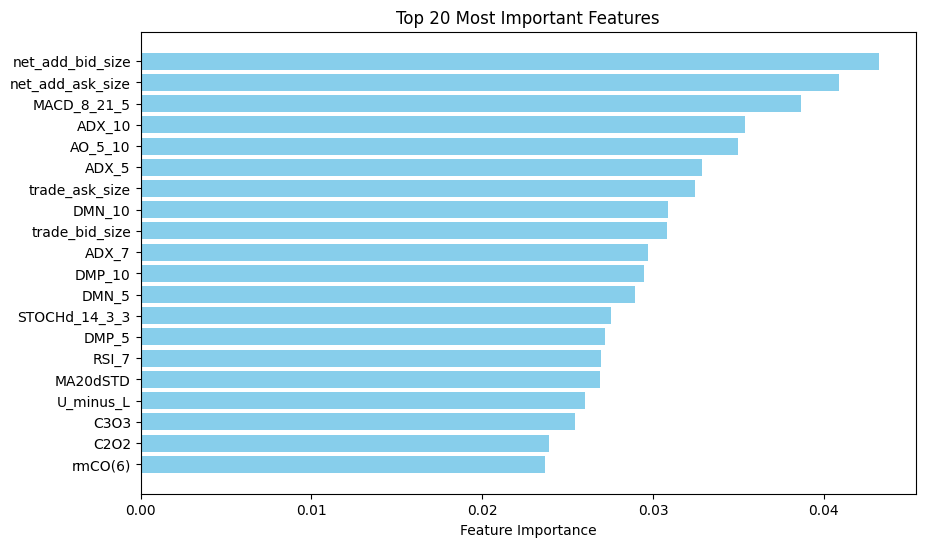

Top 20 Most Important Features:
             Feature  Importance
3   net_add_bid_size    0.034826
35         U_minus_L    0.032583
36          MA20dSTD    0.031953
2   net_add_ask_size    0.031700
21       MACD_8_21_5    0.031675
6             ADX_10    0.030813
10            DMN_10    0.030791
4              ADX_5    0.029817
23           AO_5_10    0.029663
5              ADX_7    0.029439
9              DMN_5    0.026851
22             RSI_7    0.026720
8             DMP_10    0.026550
7              DMP_5    0.025359
20     STOCHd_14_3_3    0.024464
40              C3O3    0.024431
0     trade_ask_size    0.024019
1     trade_bid_size    0.023928
39              C2O2    0.023214
34   Bollinger_Lower    0.023165


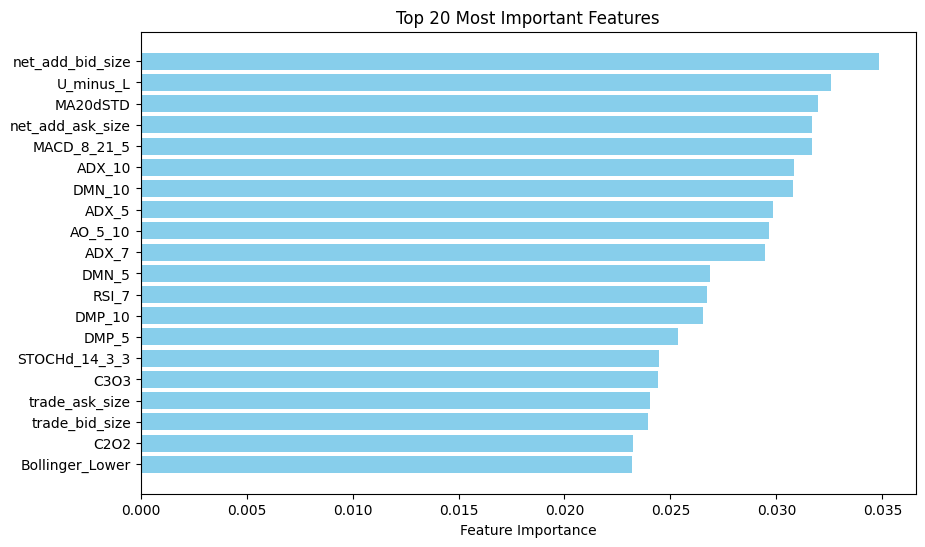

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = all_data.drop(columns=['returns', 'volatilities'])  # Features
y = all_data['returns']  # Target variable

params0 = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}
params1 = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

params2={
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 10,
    'min_samples_leaf': 5
}
params3={
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features' : 0.3
}

def analyze_feature_importance(X, y, num_features=20, **rf_params):
    """
    Analyze and visualize feature importance using a Random Forest model.

    Parameters:
        X (pd.DataFrame): DataFrame containing the features.
        y (pd.Series): Series containing the target variable.
        num_features (int): Number of top features to display and plot.
        **rf_params: Additional parameters to pass to RandomForestClassifier.

    Returns:
        importance_df (pd.DataFrame): DataFrame containing features and their importance scores.
    """
    # Initialize the Random Forest model
    rf = RandomForestRegressor(**rf_params)

    # Train the model on the entire dataset
    rf.fit(X, y)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame to display feature importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })

    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display the top `num_features` most important features
    print(f"Top {num_features} Most Important Features:")
    print(importance_df.head(num_features))

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:num_features], importance_df['Importance'][:num_features], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Top {num_features} Most Important Features')
    plt.gca().invert_yaxis() 
    plt.show()

    return importance_df

importance_df0 = analyze_feature_importance(X, y, **params0)
importance_df1 = analyze_feature_importance(X, y, **params1)
importance_df2 = analyze_feature_importance(X, y, **params2)
importance_df3 = analyze_feature_importance(X, y, **params3)

Top 9 Most Important Features:
   Feature  Importance
6   DMN_10    0.095131
2   ADX_10    0.094867
0    ADX_5    0.091686
4   DMP_10    0.089832
3    DMP_5    0.089740
5    DMN_5    0.087161
1    ADX_7    0.081537
14    OHH5    0.057774
12   OLL15    0.056754


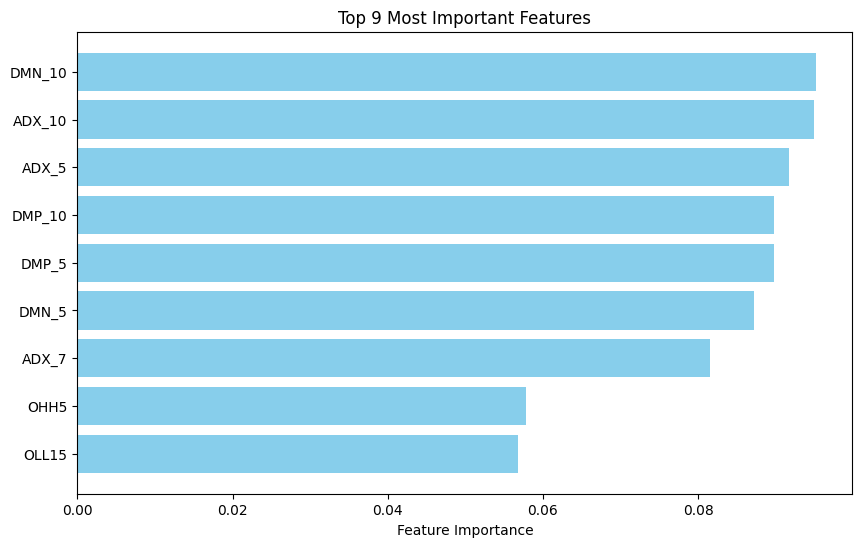

Top 9 Most Important Features:
   Feature  Importance
6   DMN_10    0.096418
0    ADX_5    0.092215
2   ADX_10    0.092043
4   DMP_10    0.089940
3    DMP_5    0.087893
5    DMN_5    0.087131
1    ADX_7    0.081011
14    OHH5    0.057252
12   OLL15    0.057242


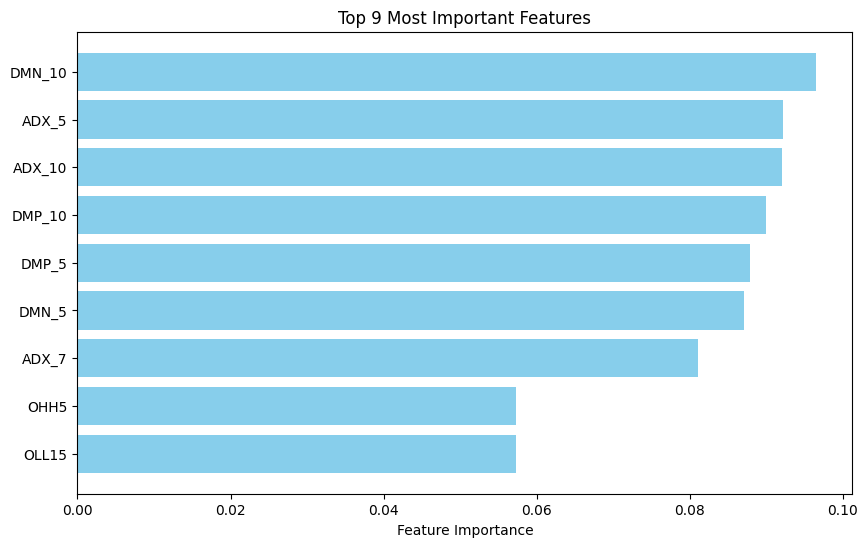

Top 9 Most Important Features:
   Feature  Importance
6   DMN_10    0.096366
4   DMP_10    0.093660
0    ADX_5    0.092828
2   ADX_10    0.092463
3    DMP_5    0.087997
5    DMN_5    0.086358
1    ADX_7    0.082053
14    OHH5    0.061213
12   OLL15    0.059362


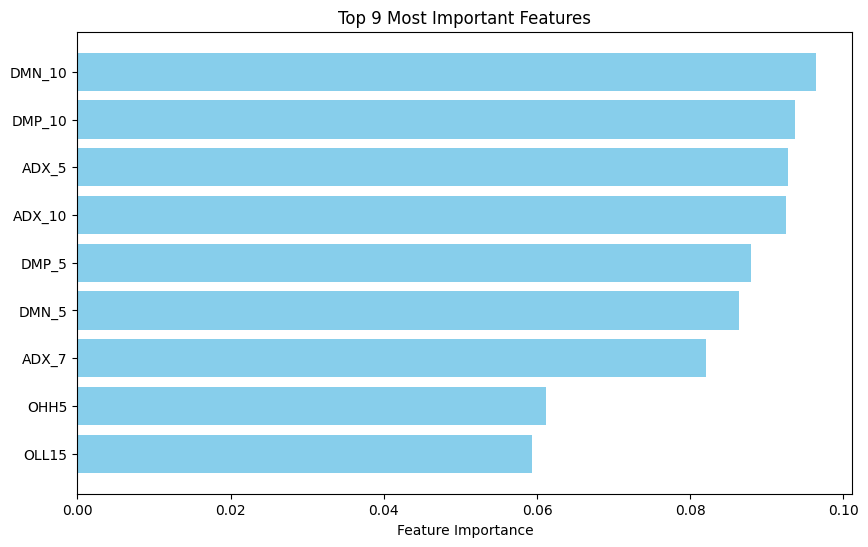

In [ ]:
trend_indicators = ['ADX_5', 'ADX_7', 'ADX_10', 'DMP_5', 'DMP_10', 'DMN_5', 'DMN_10', 'AROONU_7', 'AROOND_7', 'OLL3', 'OLL5', 'OLL10', 'OLL15', 'OHH3', 'OHH5']
oscillators =[ 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'MACD_8_21_5', 'RSI_7', 'AO_5_10']
moving_averages = ['EMA_15', 'HMA_10', 'KAMA_3_2_10', 'MA_10', 'MA_20', 'rmCO(3)', 'rmCO(4)', 'rmCO(5)', 'rmCO(6)']
volatility_indicators = ['Bollinger_Upper', 'Bollinger_Lower', 'U_minus_L', 'MA20dSTD']
other_indicators = ['CO', 'C1O1', 'C2O2', 'C3O3', 'range', 'OH1']

price_indicators = ['mid_price_high', 'mid_price_low', 'mid_price_last', 'mid_price_first']
order_sizes_indicators = ['net_add_ask_size', 'net_add_bid_size', 'trade_ask_size', 'trade_bid_size']

importance_df_trend0 = analyze_feature_importance(X[trend_indicators], y, num_features=9, **params0)
importance_df_trend1 = analyze_feature_importance(X[trend_indicators], y, num_features=9, **params1)
importance_df_trend2 = analyze_feature_importance(X[trend_indicators], y, num_features=9, **params2)

# PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_feature_selection(df, n_components=None, variance_threshold=0.95, num_features_to_keep=20):
    """
    Perform PCA-based feature selection and visualize the importance of the selected features.

    Parameters:
    - df: pandas DataFrame, the input dataset.
    - n_components: int or None, the number of principal components to keep. If None, it will be determined by the variance_threshold.
    - variance_threshold: float, the cumulative explained variance threshold to use if n_components is None.
    - num_features_to_keep: int, the number of top features to select.

    Returns:
    - features_to_keep: list, the names of the selected features.
    - sum_loadings: numpy array, the importance scores of the selected features.
    - selected_components_df: pandas DataFrame, the PCA components for the selected features.
    """
    # Step 1: Extract feature names and data
    features = df.columns.tolist() 
    X = df.values 

    # Step 2: Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 3: Apply PCA
    if n_components is None:
        # Compute all components to analyze explained variance
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)
        
        # Calculate cumulative explained variance
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        # Determine the number of components to retain based on the variance threshold
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        print(f"Selected {n_components} components to explain {variance_threshold * 100}% of the variance.")
        
        # Re-fit PCA with the selected number of components
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
    else:
        # Use the specified number of components
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)

    # Step 4: Get PCA components (loadings)
    components = pca.components_  # Each row is a principal component, each column is a feature
    components_df = pd.DataFrame(components, columns=features, index=[f'PC{i+1}' for i in range(len(components))])

    # Step 5: Calculate absolute factor loadings and sum them
    absolute_loadings = np.abs(components)  # Absolute values of loadings
    sum_loadings = np.sum(absolute_loadings, axis=0)  # Sum of loadings for each feature

    # Step 6: Sort features by importance
    sorted_indices = np.argsort(sum_loadings)[::-1]  # Indices of features sorted by importance

    # Step 7: Select top features
    features_to_keep = [features[i] for i in sorted_indices[:num_features_to_keep]]  # Top features

    # Step 8: Display results
    print("Top Features to Keep:", features_to_keep)
    print("\nImportance of Selected Features:")
    for feature in features_to_keep:
        index = features.index(feature)
        print(f"{feature}: Importance = {sum_loadings[index]:.4f}")

    # Step 9: Display PCA components for selected features
    selected_components_df = components_df[features_to_keep]
    print("\nPCA Components for Selected Features:")
    print(selected_components_df)

    # Step 10: Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features_to_keep), sum_loadings[sorted_indices[:num_features_to_keep]], align='center', color='skyblue')
    plt.xticks(range(num_features_to_keep), features_to_keep, rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance (Sum of Absolute Loadings)')
    plt.title('Top Features by Importance')
    plt.tight_layout()
    plt.show()

    return features_to_keep, sum_loadings, selected_components_df

Selected 19 components to explain 95.0% of the variance.
Top Features to Keep: ['trade_bid_size', 'trade_ask_size', 'net_add_bid_size', 'net_add_ask_size', 'volatilities', 'C3O3', 'DMP_10', 'AROONU_7', 'DMN_10', 'AROOND_7', 'C2O2', 'STOCHk_14_3_3', 'OHH3', 'OH1', 'DMP_5', 'MA20dSTD', 'U_minus_L', 'STOCHd_14_3_3', 'DMN_5', 'AO_5_10']

Importance of Selected Features:
trade_bid_size: Importance = 3.3957
trade_ask_size: Importance = 3.3535
net_add_bid_size: Importance = 3.2003
net_add_ask_size: Importance = 3.1248
volatilities: Importance = 2.6962
C3O3: Importance = 2.6609
DMP_10: Importance = 2.6437
AROONU_7: Importance = 2.5576
DMN_10: Importance = 2.4994
AROOND_7: Importance = 2.4751
C2O2: Importance = 2.4361
STOCHk_14_3_3: Importance = 2.2765
OHH3: Importance = 2.2248
OH1: Importance = 2.1968
DMP_5: Importance = 2.1927
MA20dSTD: Importance = 2.1412
U_minus_L: Importance = 2.1412
STOCHd_14_3_3: Importance = 2.1400
DMN_5: Importance = 2.1141
AO_5_10: Importance = 2.0460

PCA Components 

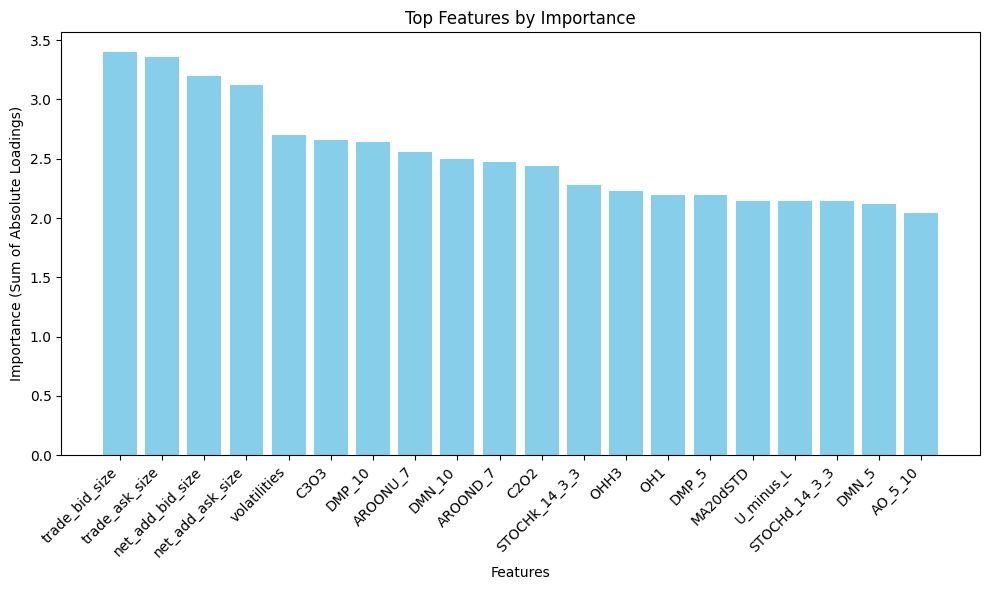

In [ ]:
# Change all_data to select feature categories
features_to_keep, sum_loadings, selected_components_df = pca_feature_selection(
    all_data,  num_features_to_keep=20
)

Selected 8 components to explain 95.0% of the variance.
Top Features to Keep: ['AROOND_7', 'AROONU_7', 'OLL3', 'OLL15']

Importance of Selected Features:
AROOND_7: Importance = 2.2631
AROONU_7: Importance = 2.2136
OLL3: Importance = 2.0699
OLL15: Importance = 1.9600

PCA Components for Selected Features:
     AROOND_7  AROONU_7      OLL3     OLL15
PC1 -0.288774  0.326452  0.167489  0.330938
PC2  0.165757 -0.016420  0.310279  0.222670
PC3 -0.193065  0.011673 -0.347750 -0.166762
PC4  0.006756  0.164239 -0.250614 -0.102069
PC5  0.371207  0.277635  0.144793 -0.247136
PC6  0.618355 -0.387588  0.201022 -0.093216
PC7  0.106781  0.715818  0.193959 -0.313455
PC8  0.512386  0.313742 -0.453999  0.483729


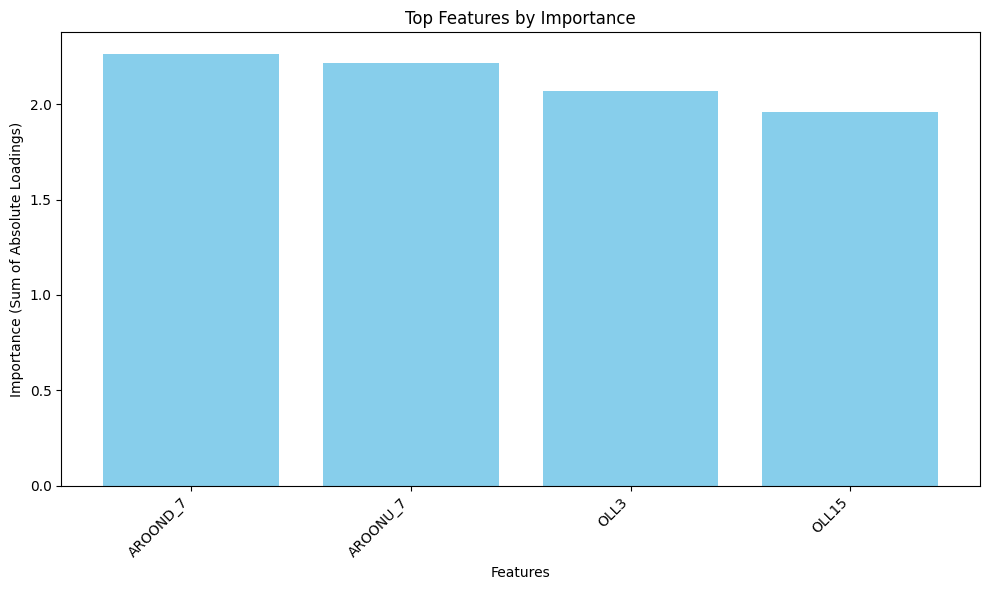

In [ ]:
# Change all_data to select feature categories
features_to_keep, sum_loadings, selected_components_df = pca_feature_selection(
    all_data[trend_indicators],  num_features_to_keep=4
)